# Climate modes and diagnostics

In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [2]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = '03:00:00'
cores = 10
memory = str(4 * cores) + 'GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=['-q normal',
                                           '-P w42',
                                           '-l ncpus='+str(cores),
                                           '-l mem='+str(memory),
                                           '-l storage=gdata/w42+gdata/rt52'],
                     local_directory='$TMPDIR',
                     job_directives_skip=["select"])

In [3]:
cluster.scale(jobs=1)
client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.7:39613,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
# import warnings

import xarray as xr
import numpy as np
import regionmask

import xskillscore as xs

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.crs as ccrs
import cartopy
cartopy.config['pre_existing_data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'
cartopy.config['data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'
from cartopy.util import add_cyclic_point

import string
letters = list(string.ascii_lowercase)

In [7]:
%cd /g/data/w42/dr6273/work/AEMO_compound_events/

import functions as fn

/g/data/w42/dr6273/work/AEMO_compound_events


In [8]:
plt_params = fn.get_plot_params()
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [9]:
plt_params

{'lines.linewidth': 1.3,
 'hatch.linewidth': 0.5,
 'font.size': 7,
 'legend.fontsize': 6,
 'legend.columnspacing': 0.7,
 'legend.labelspacing': 0.03,
 'legend.handlelength': 1.0,
 'axes.linewidth': 0.5,
 'axes.titlesize': 8}

In [10]:
years = range(1959, 2022)

data_fp = '/g/data/w42/dr6273/work/data/'

season_dict = fn.get_seasons()

# Load masks

In [11]:
rez_mask = fn.get_rez_mask()

# Load energy source and demand data

Sources: daily wind, daily solar and monthly runoff

In [12]:
rez_100w = xr.open_zarr(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/100w_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region_mean.zarr',
    consolidated=True
)['100w']#.compute()

In [13]:
rez_mssrd = xr.open_zarr(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/mssrd_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region_mean.zarr',
    consolidated=True
)['mssrd']#.compute()

Aus - gridded

In [14]:
aus_100w = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/100w/100w_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_AUS_region.zarr',
    consolidated=True
)['w100']

In [15]:
aus_mssrd = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/msdwswrf/msdwswrf_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_AUS_region.zarr',
    consolidated=True
)['msdwswrf']

Thresholds for event definitions

In [16]:
thresh_100w = rez_100w.chunk({'time': -1}).quantile(0.25, ['time', 'region']) #4 # Close to all region-time 25th percentile of 4.19
thresh_mssrd = rez_mssrd.chunk({'time': -1}).quantile(0.25, ['time', 'region']) #170 # All region-time 25th percentile is 132.7

### Events

In [17]:
events_100w = fn.get_events(rez_100w, thresh_100w, tail='lower').compute()

In [18]:
events_mssrd = fn.get_events(rez_mssrd, thresh_mssrd, tail='lower').compute()

In [19]:
events_100w_mssrd = fn.get_compound_events(rez_100w, rez_mssrd, thresh_100w, thresh_mssrd).compute()

### Daily events over all regions

In [20]:
simul_100w = fn.concurrent_lulls(events_100w, [1, 3, 5, 7], rez_mask)
simul_mssrd = fn.concurrent_lulls(events_mssrd, [2, 3, 6, 7], rez_mask)
simul_100w_mssrd = fn.concurrent_lulls(events_100w_mssrd, [3, 7], rez_mask)

### Seasonal events over all regions

In [21]:
season_100w = fn.seasonal_mean(simul_100w)
season_mssrd = fn.seasonal_mean(simul_mssrd)
season_100w_mssrd = fn.seasonal_mean(simul_100w_mssrd)

# Load diagnostics and climate mode indices

### Monthly diagnostics and seasonal means

HadISST SST anomalies

In [22]:
sst_fp = data_fp + 'hadisst/sst/sst_anom_hadisst_moda_sfc_'+str(years[0])+'-'+str(years[-1])+'.zarr'
sst_anoms = xr.open_zarr(sst_fp, consolidated=True)
sst_anoms = fn.seasonal_mean(sst_anoms)

ERA5 MSLP anomalies

In [23]:
mslp_fp = data_fp + 'era5/mslp/mslp_anom_era5_moda_sfc_'+str(years[0])+'-'+str(years[-1])+'.zarr'
mslp_anoms = xr.open_zarr(mslp_fp, consolidated=True)
mslp_anoms = fn.seasonal_mean(mslp_anoms)

### Climate mode indices

Nino3.4

In [24]:
nino34_fp = data_fp + 'hadisst/climate_modes/hadisst_nino34_'+str(years[0])+'-'+str(years[-1])+'.zarr'
nino34 = xr.open_zarr(nino34_fp, consolidated=True)
nino34 = fn.seasonal_mean(nino34)
nino34 = nino34.compute()

DMI

In [25]:
dmi_fp = data_fp + 'hadisst/climate_modes/hadisst_dmi_'+str(years[0])+'-'+str(years[-1])+'.zarr'
dmi = xr.open_zarr(dmi_fp, consolidated=True)
dmi = fn.seasonal_mean(dmi)
dmi = dmi.compute()

SAM

In [26]:
sam_fp = data_fp + 'era5/climate_modes/era5_sam_'+str(years[0])+'-'+str(years[-1])+'.zarr'
sam = xr.open_zarr(sam_fp, consolidated=True)
sam = fn.seasonal_mean(sam)
sam = sam.compute()

# Monthly diagnostics on spatially extensive wind/solar/compound drought years

### Set variables

In [27]:
thresh_spatial = 0.9

### Composite maps

In [29]:
def plot_sst_mslp(ax, sst_da, mslp_da, years, text=None):
    """
    Plot SST shading and MSLP contours on an axis.
    """
    m = 5000
    mslp_levels = np.arange(-m, m+1, 100)
    mslp_levels = [i for i in mslp_levels if i != 0]
    
    ax.set_extent([0, 359.99, 20, -90])
    ax.coastlines(linewidths=0.3, rasterized=True)
    
    p = sst_da.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        vmin=-1.8,
        vmax=1.8,
        cmap='RdBu_r',
        add_colorbar=False,
        rasterized=True
    )
    mslp_da.plot.contour(
        ax=ax,
        transform=ccrs.PlateCarree(),
        levels=mslp_levels,
        colors='k',
        linewidths=0.3
    )
    
    if isinstance(text, str):
        ax.text(0.93, 0.93, text, ha='right', va='top',
                bbox=dict(facecolor='white', alpha=1, lw=0.5),
                transform=ax.transAxes)
    
    format_years = [str(i) for i in years]
    title = ', '.join(format_years)
    ax.set_title(title, fontsize=plt_params['font.size'] / 1.7, pad=0)
    
    return p

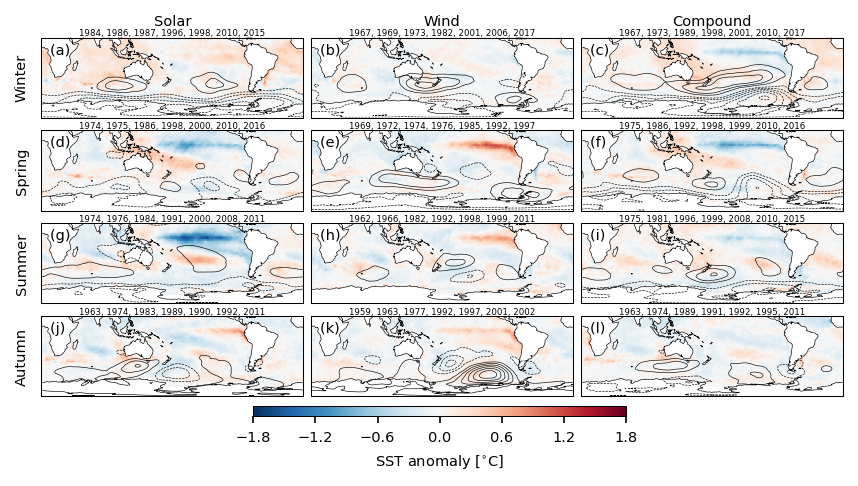

In [30]:
with plt.rc_context(plt_params):
    fig = plt.figure(figsize=(6.9, 3.2), dpi=150)
    
    axes = []
    for i in range(12):
        axes.append(fig.add_subplot(4, 3, i+1, projection=ccrs.PlateCarree(central_longitude=180)))
    
    i = 0
    for season in list(season_dict.keys())[1:]:
        for var in [season_mssrd, season_100w, season_100w_mssrd]:
            years, n_events, p_sst = fn.composite_data(
                var,
                sst_anoms['sst_anom'],
                season,
                thresh_spatial
            )

            _, _, p_mslp = fn.composite_data(
                var,
                mslp_anoms['mslp_anom'],
                season,
                thresh_spatial
            )

            ax = axes[i]
            p = plot_sst_mslp(ax, p_sst, p_mslp, years)
            label = '(' + letters[i] + ') '
            ax.text(0.035, 0.8, label, transform=ax.transAxes)
            
            i += 1
                        
    plt.subplots_adjust(hspace=0.02, wspace=0.03)
    
    axes[0].text(0.5, 1.15, 'Solar', ha='center', transform=axes[0].transAxes)
    axes[1].text(0.5, 1.15, 'Wind', ha='center', transform=axes[1].transAxes)
    axes[2].text(0.5, 1.15, 'Compound', ha='center', transform=axes[2].transAxes)
    
    axes[0].text(-0.1, 0.5, 'Winter', rotation=90, va='center', transform=axes[0].transAxes)
    axes[3].text(-0.1, 0.5, 'Spring', rotation=90, va='center', transform=axes[3].transAxes)
    axes[6].text(-0.1, 0.5, 'Summer', rotation=90, va='center', transform=axes[6].transAxes)
    axes[9].text(-0.1, 0.5, 'Autumn', rotation=90, va='center', transform=axes[9].transAxes)
    
    cb_ax1 = fig.add_axes([0.33, 0.08, 0.36, 0.02])
    cb1 = fig.colorbar(p, cax=cb_ax1, orientation='horizontal', ticks=np.arange(-1.8, 1.9, 0.6))
    cb1.ax.set_xlabel(r'SST anomaly [$^{\circ}$C]')
    
    plt.savefig('./figures/Fig3_composites.pdf', format='pdf', dpi=400, bbox_inches='tight')

### Climate modes PDFS

In [28]:
def mode_hist(ax, event_da_list, diag_da, season, q, xmin=-2.5, xmax=2.5, nbins=20, time_name='time'):
    """
    Get the histogram of diag_da for the season, and the individual
    points for values of diag_da on event years for each event in
    event_da_list.
    """
    event_values = []
    # Loop through event_da_list (usually wind, solar and compound) to get mode index
    #  values on events.
    for i, event_da in enumerate(event_da_list):
        years, events, _, diag_events = fn.subset_on_events(event_da, diag_da, season, q, time_name)
        event_values.append(diag_events.where(events.notnull()).dropna(time_name).values)
    diag_season = fn.month_subset(diag_da, fn.get_seasons()[season])

    # Histogram
    b = np.linspace(xmin, xmax, nbins)
    bins, hist = fn.hist_data(diag_season, b)
    
    ax.plot(bins, hist, color='k', lw=0.5)
    ax.fill_between(bins, 0, hist, color='k', alpha=0.15)
    
    # +- x * standard deviations
    std = diag_season.std(time_name).values
    ax.axvline(std * 1, ls='--', lw=0.5, color='k')
    ax.axvline(std * -1, ls='--', lw=0.5, color='k')
    
    # Get ymax rounded up
    ymax = fn.round_decimals_up(np.max(hist), 1)
    # Use this to set y location of markers
    central_y = ymax / 9
    lower_y = central_y / 2.3
    upper_y = central_y * 1.8
    
    for values, y, marker, color, label in zip(
        event_values,
        [lower_y, central_y, upper_y],
        ['*', 'x', '.'],
        [colors[1], colors[0], colors[4]],
        ['Solar', 'Wind', 'Compound']
    ):
        s = ax.scatter(values, np.repeat(y, len(values)), color=color, marker=marker, s=10, lw=0.5, label=label)
        
    ax.set_xlim(xmin, xmax)
    
    # yticks (surely a better way exists...)
    if ymax > 1:
        ax.set_yticks(np.arange(0, 1.9, 0.6))
    elif (ymax <= 1) & (ymax > 0.8):
        ax.set_yticks(np.arange(0, 1.1, 0.5))
    elif (ymax <= 0.8) & (ymax > 0.5):
        ax.set_yticks(np.arange(0, 0.81, 0.4))
    else:
        ax.set_yticks(np.arange(0, 0.5, 0.2))
        
    return s

#### Print some stats

In [29]:
e_da = season_100w_mssrd
m_da = sam['sam']
season = 'Winter'

# for i, event_da in enumerate(event_da_list):
years, events, _, diag_events = fn.subset_on_events(e_da, m_da, season, thresh_spatial, 'time')
print(diag_events.where(events.notnull()).dropna('time').values)
print(years)

[0.6771739  0.6789265  1.4623736  3.3980808  0.72280353 3.39836
 1.6517311 ]
[1967 1973 1989 1998 2001 2010 2017]


In [42]:
e_da = season_mssrd
m_da = nino34['nino34']
season = 'Summer'

# for i, event_da in enumerate(event_da_list):
years, events, _, diag_events = fn.subset_on_events(e_da, m_da, season, thresh_spatial, 'time')
print(diag_events.where(events.notnull()).dropna('time').values)
print(years)

[-1.8821317  -1.4832062  -0.7339161   0.39295626 -1.6008415  -1.6774222
 -1.5080743 ]
[1974 1976 1984 1991 2000 2008 2011]


# Difference in drought prob between +ve and -ve phase of modes

Compute lull frequency during +ve phase years, subtract lull frequency during -ve phase years, plot map.

In [29]:
def seasonal_sum(da, time_name='time'):
    """
    Calculate seasonal sums. Currently assumes da starts in January.
    First aggregates to monthly, then shifts everything forwards
    one month, then aggregates over 3 months.
    """
    first_month = da[time_name].dt.month.values[0]
    if first_month != 1:
        raise ValueError("First month should be January. Adjust da or function.")
        
    # First aggregate to monthly as we want to shift a month ahead
    m_da = da.resample({time_name: '1MS'}).sum()
    # Now shift a month ahead and calculate 3-monthly means
    return m_da.shift({time_name: 1}).resample({time_name: '3MS'}).sum(skipna=False)

In [30]:
def subset_by_phase(event_da, diag_da, season, time_name='time'):
    """
    Subset an events dataArray by positive and negative phases of climate modes.
    
    event_da: DataArray of daily events
    diag_da: mode DataArray
    season: season of interest
    """
    # diag_da subset by season
    diag_season = fn.month_subset(diag_da, fn.get_seasons()[season])
    # +- x standard deviation thresholds
    std = diag_season.std(time_name).values
    low_thresh = std * -1
    high_thresh = std * 1
    
    # Events subset by diag_season
    low_events = event_da.where(diag_season < low_thresh)
    high_events = event_da.where(diag_season > high_thresh)
    
    return low_events, high_events

In [31]:
def event_diff(event_da, diag_da, season, scale=None, time_name='time'):
    """
    Difference in number of events, computed as event frequency during
    positive mode phases minus event frequency during negative mode phases.
    
    Can be scaled by the standard deviation to say e.g. wind droughts during
    positive ENSO are more frequent on average that during negative ENSO by
    2 standard deviations.
    """
    # Subset events by negative and positive phases of mode
    neg, pos = subset_by_phase(event_da, diag_da, season, time_name)
    
    neg_m = neg.mean(time_name)
    pos_m = pos.mean(time_name)
    diff = (pos_m - neg_m)
    
    if scale == 'std':
        return  diff / event_da.std(time_name)
    else:
        return diff

First get gridded events

In [32]:
aus_events_mssrd = fn.get_events(aus_mssrd, thresh_mssrd, tail='lower')
aus_events_100w = fn.get_events(aus_100w, thresh_100w, tail='lower')
aus_events_100w_mssrd = fn.get_compound_events(aus_100w, aus_mssrd, thresh_100w, thresh_mssrd)

Now get the seasonal totals

In [33]:
aus_events_mssrd_seasonal_total = seasonal_sum(aus_events_mssrd).compute()
aus_events_100w_seasonal_total = seasonal_sum(aus_events_100w).compute()
aus_events_both_seasonal_total = seasonal_sum(aus_events_100w_mssrd).compute()

### Bootstrapping

We want to:
- Draw a bootstrap sample of seasons equal in length to the observations
- From this sample, randomly select two sets of seasons, equal in length to the number of seasons above and below the thresholds for +ve and -ve climate mode phases.
- Subtract these from each other.
- Repeat 10000 times
- Compare obs with this 10,000-size sample


In [91]:
def permutation(
    event_da,
    mode_da,
    season,
    n_iter=100,
    lower_q=0.05,
    upper_q=0.95
):
    """
    Compute statistical significance for difference in number of drought
    days between positive and negative mode phases.
    
    DESCRIBE FUNCTION
    
    event_da: array to resample
    mode_da: array used to obtain subsample sizes
    season: season to process
    n_iter: number of iterations
    lower_q, upper_q: [0,1], quantiles to assign significance
    """
    # Get observed differences
    obs_da = event_diff(event_da, mode_da, season)
    
    # Season for event_da and obs_da
    months = fn.get_seasons()[season]
    event_da = fn.month_subset(event_da, months)
    
    # Sample sizes of subsamples (from climate mode series)
    mode = fn.month_subset(mode_da, months)
    n = len(mode["time"])
    n_neg = mode.where(mode < -1 * mode.std("time")).count().values
    n_pos = mode.where(mode > mode.std("time")).count().values
    print(n_neg, n_pos)
    
    # Use xskillscore
    da_list = []
    
    pos_list = []
    neg_list = []
    
    sub_iter = n_iter // 100
    for i in range(100): # xskillscore isn't great for large iteration sizes, so do in stages

        perm_pos = xs.resample_iterations_idx(
            event_da,
            sub_iter,
            dim="time",
            replace=False,
            dim_max=n_pos
        )

        perm_neg = xs.resample_iterations_idx(
            event_da,
            sub_iter,
            dim="time",
            replace=False,
            dim_max=n_neg
        )
        
        pos_list.append(perm_pos)
        neg_list.append(perm_neg)

        perm_stat = perm_pos.mean("time") - perm_neg.mean("time")
        perm_stat = perm_stat.assign_coords(
            {"iteration": range(sub_iter * i, sub_iter * i + sub_iter)}
        )

        da_list.append(perm_stat)
    perm = xr.concat(da_list, dim="iteration")
    
    quantiles = (perm < obs_da).mean("iteration")

    pvals = quantiles.where(obs_da <= 0, 1 - quantiles)

    return pvals, xr.concat(pos_list, dim="iteration"), xr.concat(neg_list, dim="iteration")

In [35]:
def fdr(p_values_da, alpha=0.1):
    """
    Calculates significance on a DataArray of gridded p-values (p_values_da)
    by controlling the false discovery rate.
    Returns a DataArray of ones (significant) and zeros (not significant).
    
    p_values_da: array of p-values
    alpha: significance level (often double the alpha in standard hypothesis test)
    """
    p_1d = p_values_da.values.reshape(-1) # 1-D array of p-values
    p_1d = p_1d[~np.isnan(p_1d)] # Remove NaNs
    
    sorted_pvals = np.sort(p_1d) # sort p-values
    N = len(sorted_pvals) # sample size
    
    fdr_criteria = alpha * (np.arange(1, N+1) / N) # the diagonal line of criteria
    pvals_less_than_fdr_criteria = np.where(sorted_pvals < fdr_criteria)[0]
    
    if len(pvals_less_than_fdr_criteria) > 0: #if any p-values satisfy the FDR criteria
        # index of the largest p-value still under the fdr_criteria line.
        largest_p_less_than_criteria = pvals_less_than_fdr_criteria[-1]
        # the p-value for controlling the FDR
        p_fdr = sorted_pvals[largest_p_less_than_criteria] 
    else:
        p_fdr = -1 # abritrary number < 0. Ensures no significant results.
    
    # massage data into binary indicators of FDR significance
    keep_signif = p_values_da.where(p_values_da <= p_fdr, -999)
    signif_da = keep_signif.where(keep_signif == -999, 1)
    signif_da = signif_da.where(signif_da == 1, 0)
    
    return signif_da.where(p_values_da.notnull(), np.nan), sorted_pvals, fdr_criteria

### Land mask

Need a mask to remove ocean cells as we don't test these.

In [36]:
mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(
    aus_events_both_seasonal_total["lon"],
    aus_events_both_seasonal_total["lat"]
)

In [38]:
def plot_mode_diff(ax, event_da, mode_da, season, scale, vmin, vmax, label, signif=False):
    """
    Plot difference in mean event frequency between positive
    and negative phases of a climate mode.
    """
    ax.set_extent([112, 155, -10, -44])
    ax.add_feature(
        cartopy.feature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces',
            scale='10m'
        ),
        facecolor='none',
        edgecolor='k',
        lw=.1,
        rasterized=True
    )
    ax.add_feature(
        cartopy.feature.OCEAN, facecolor='white', zorder=1, rasterized=True
    )
    ax.coastlines(lw=.3, rasterized=True, zorder=2)
    
    diff = event_diff(event_da, mode_da, season, scale)
        
    # Set cmap limits and ensure cbar extends correctly
    p_min = diff.min().values
    p_max = diff.max().values
    
    if (p_min < vmin) & (p_max <= vmax):
        cbar_extend = 'min'
    elif (p_min < vmin) & (p_max > vmax):
        cbar_extend = 'both'
    elif (p_min >= vmin) & (p_max <= vmax):
        cbar_extend = 'neither'
    elif (p_min >= vmin) * (p_max > vmax):
        cbar_extend = 'max'
    else:
        raise ValueError('Something weird happening with vmin/vmax')
        
    cbar_kwargs = {'extend': cbar_extend, 'label': label}
    
    diff.plot(cmap='RdBu_r', vmin=vmin, vmax=vmax, cbar_kwargs=cbar_kwargs, rasterized=True, zorder=0)
    
    if signif:
        # Permutation test
        pvals, _, _ = permutation(
            event_da.chunk(),
            mode_da,
            season,
            n_iter=5000
        )
        
        # False Discovery Rate
        # Test has been run on ocean grid cells, but we don't want these,
        # so first apply a mask to ensure ocean tests contribute to FDR
        pvals_masked = pvals.where(mask == 0)
        p_fdr, _, _ = fdr(pvals_masked)
        
        # Plot
        # p_fdr.plot.contour(colors="k", levels=[-1e-6, 1e-6], zorder=0, linewidths=0.7)
        fdr_da = xr.where(p_fdr == 1, 1, np.nan).values
        cyclic_fdr, cyclic_lon = add_cyclic_point(fdr_da, coord=p_fdr.lon)
        ax.pcolor(cyclic_lon, p_fdr.lat, cyclic_fdr,
                  hatch='//', shading='auto', alpha=0, rasterized=False,
                 zorder=0)
        
    ax.set_title('')
    
    return pvals

9 8


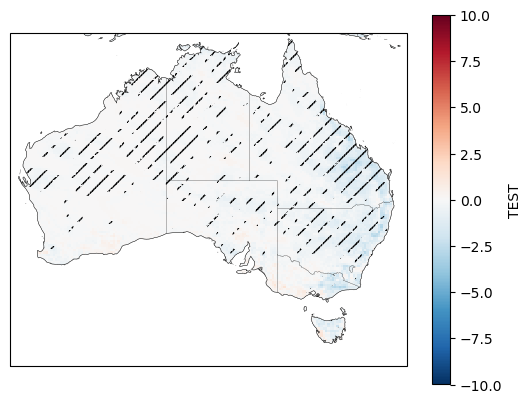

In [92]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})

p = plot_mode_diff(
    ax,
    aus_events_both_seasonal_total,
    nino34['nino34'],
    "Spring",
    None,
    -10,
    10,
    'TEST',
    signif=True
)

In [40]:
s, pv, c = fdr(p.where(mask == 0))

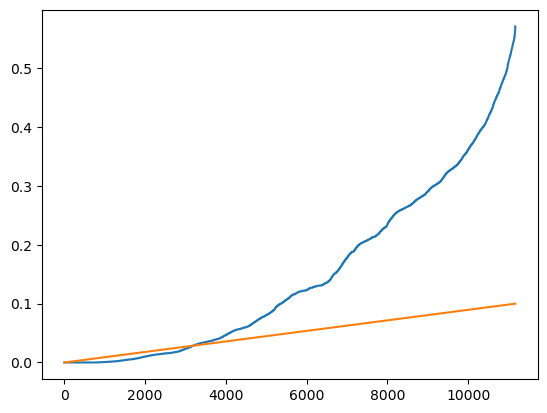

In [41]:
plt.plot(pv)
plt.plot(c)

# To check:

Look at the difference in means between the two random subsamples. Are the magnitudes small enough to justify the significance shown on the map above?

In [51]:
pvals, pos, neg = permutation(
    aus_events_both_seasonal_total.chunk(),
    nino34['nino34'],
    'Spring',
    n_iter=5000
)

In [66]:
obs = event_diff(aus_events_both_seasonal_total, nino34['nino34'], "Spring")

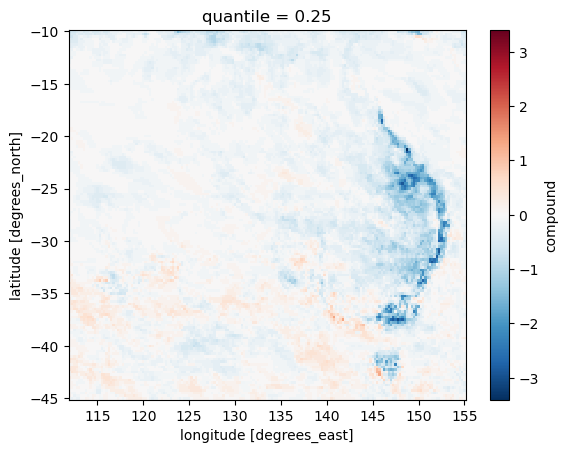

In [57]:
obs.plot()

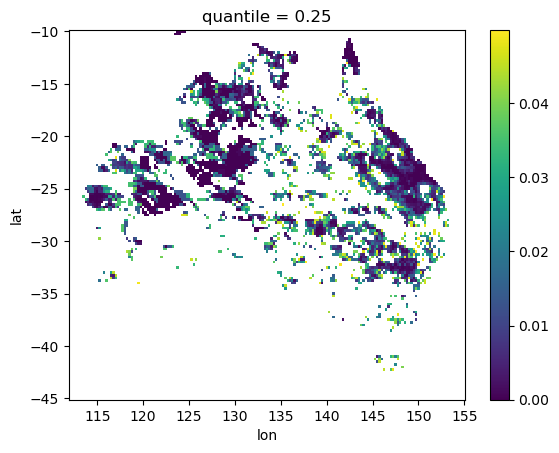

In [48]:
pvals.where(pvals < 0.05).where(mask==0).plot()

(array([9085., 2440., 3000., 2233., 2352., 1978., 1309.,  839.,  611.,
         546.]),
 array([0.     , 0.05774, 0.11548, 0.17322, 0.23096, 0.2887 , 0.34644,
        0.40418, 0.46192, 0.51966, 0.5774 ]),
 <BarContainer object of 10 artists>)

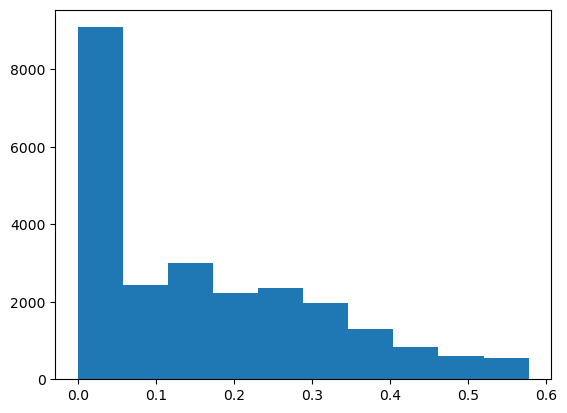

In [95]:
plt.hist(pvals.values.flatten())

In [68]:
pvals.where(pvals < 0.05).where(mask==0).sel(lat=-22, lon=130, method="nearest").values

array(0.)

In [69]:
obs.sel(lat=-22, lon=130, method="nearest")

<xarray.DataArray 'compound' ()>
array(-0.11111111)
Coordinates:
    lat       float32 -22.0
    lon       float32 130.0
    quantile  float64 0.25

In [53]:
diff = pos.mean("time") - neg.mean("time")

In [63]:
diff.chunk({"iteration": -1})

<xarray.DataArray (lat: 141, lon: 173, iteration: 5000)>
dask.array<rechunk-merge, shape=(141, 173, 5000), dtype=float64, chunksize=(141, 173, 5000), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float32 -10.0 -10.25 -10.5 -10.75 ... -44.5 -44.75 -45.0
  * lon        (lon) float32 112.0 112.2 112.5 112.8 ... 154.2 154.5 154.8 155.0
    quantile   float64 0.25
  * iteration  (iteration) int64 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49

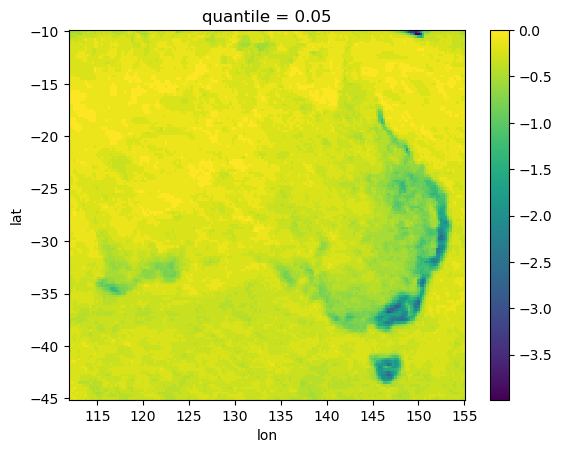

In [65]:
diff.chunk({"iteration": -1}).quantile(0.05, "iteration").plot()

In [80]:
xpos = pos.sel(lat=-22, lon=130, method="nearest")
xneg = neg.sel(lat=-22, lon=130, method="nearest")

x = diff.sel(lat=-22, lon=130, method="nearest").compute()

(array([4296.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         704.]),
 array([0.        , 0.01111111, 0.02222222, 0.03333333, 0.04444444,
        0.05555556, 0.06666667, 0.07777778, 0.08888889, 0.1       ,
        0.11111111]),
 <BarContainer object of 10 artists>)

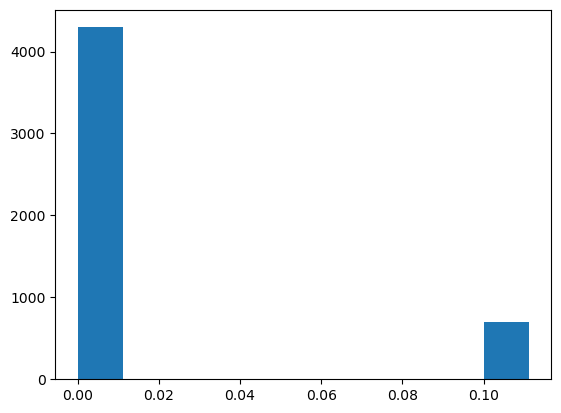

In [82]:
plt.hist(xneg.mean("time"))

In [90]:
xpos.isel(time=0).values

array([0., 0., 0., ..., 0., 0., 0.])

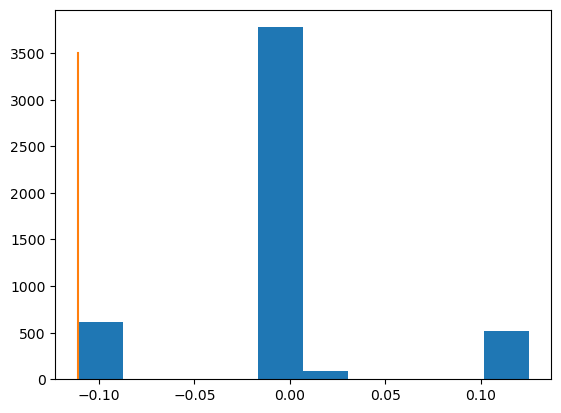

In [76]:
plt.hist(x)
plt.plot(
    (obs.sel(lat=-22, lon=130, method="nearest"), obs.sel(lat=-22, lon=130, method="nearest")),
    (0, 3500)
)

# Fig of mode hists and mode-phase event differences

In [ ]:
def fig_mode_pdf_and_diff(
    mode_xmins,
    events_list,
    season,
    scale,
    dividers,
    cbar_label='Number of\nevents [days]',
    signif=False,
    save_fig=False
):
    """
    Plot mode PDFs and diff maps for this season.
    """
    with plt.rc_context(plt_params):
        fig = plt.figure(dpi=100, figsize=(6, 5.5)) 
    
        # ===================== Mode PDFs
        mode_list = [nino34['nino34'], dmi['dmi'], sam['sam']]
        mode_names = ['ENSO', 'IOD', 'SAM']
        xlabels = [r'Ni$\mathrm{\tilde{n}}$o3.4 [$^{\circ}$C]',
                   r'DMI [$^{\circ}$C]',
                   'SAM index [-]']
        xmins = mode_xmins
        xmaxs = [-1 * i for i in xmins]
        
        # gs = fig.add_gridspec(nrows=1, ncols=3, left=0, right=1, bottom=0.85, top=1)
                
        count = 0
        for i, (mode, name, xlabel, xmin, xmax) in enumerate(zip(
            mode_list,
            mode_names,
            xlabels,
            xmins,
            xmaxs
        )):
            gs = fig.add_gridspec(nrows=1, ncols=1,
                                  left=0.0 + (0.35 * i), right=0.25 + (0.35 * i),
                                  bottom=0.85, top=1)
            ax = plt.subplot(gs[0])
            s = mode_hist(
                ax,
                [season_mssrd, season_100w, season_100w_mssrd],
                mode,
                season,
                thresh_spatial,
                xmin,
                xmax,
                nbins=15
            )
            label = '(' + letters[count] + ') '
            ax.text(0.035, 0.85, label, transform=ax.transAxes)
            ax.set_title(name)
            ax.set_xlabel(xlabel)
            if i == 2:
                ax.set_ylabel('Density [-]')
                ax.legend(loc=(1.01, 0), frameon=False)
            else:
                ax.set_ylabel(r'Density [$^{\circ}$C$^{-1}$]')

            count += 1
        # =================== Difference plots
        for i, (name, event_da, divider) in enumerate(zip(
            ['Solar', 'Wind', 'Compound'],
            events_list,
            dividers,
        )):
            gs = fig.add_gridspec(nrows=1, ncols=3, left=0, right=1, bottom=0.5 - (0.25 * i), top=0.73 - (0.25 * i))
            
            for j, (mode_da, title) in enumerate(zip(
                mode_list,
                [r'ENSO$^{+} - $ENSO$^{-}$', r'IOD$^{+} - $IOD$^{-}$', r'SAM$^{+} - $SAM$^{-}$']
            )):
                if count in [5, 8, 11]:
                    label = cbar_label
                else:
                    label = ''

                ax = plt.subplot(gs[j], projection=ccrs.PlateCarree())
                ax.text(0.03, 0.9, '(' + letters[count] + ')', transform=ax.transAxes)
                
                vmin_scaled = -10 / divider
                vmax_scaled = 10 / divider
                    
                plot_mode_diff(
                    ax,
                    event_da,
                    mode_da,
                    season,
                    scale,
                    vmin_scaled,
                    vmax_scaled,
                    label,
                    signif
                )
            
                if j == 0:
                    ax.text(-0.15, 0.5, name, rotation=90, va='center', transform=ax.transAxes)

                if i == 0:
                    ax.set_title(title)
                    
                count += 1
                
        if save_fig:
            if signif:
                plt.savefig('./figures/Fig4_modes_'+season+'_signif_perm.pdf', format='pdf', dpi=400, bbox_inches='tight')
            else:
                plt.savefig('./figures/Fig4_modes_'+season+'.pdf', format='pdf', dpi=400, bbox_inches='tight')

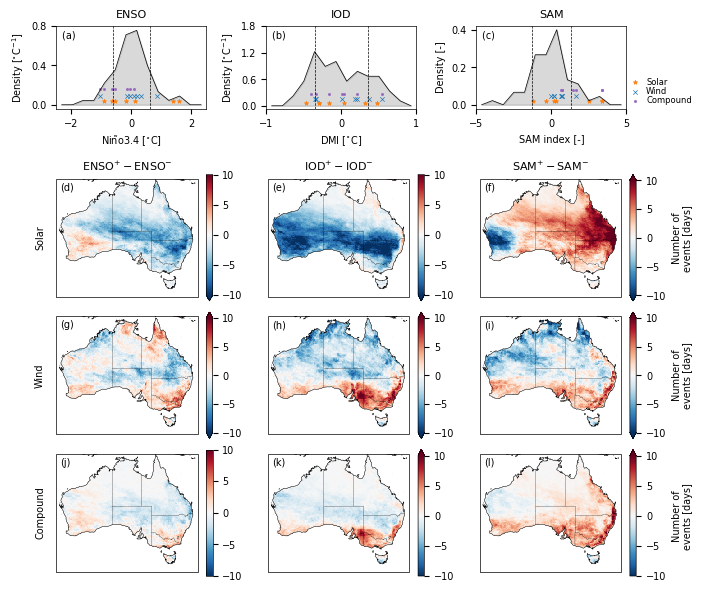

In [72]:
fig_mode_pdf_and_diff(
    [-2.5, -1, -5],
    [
    aus_events_mssrd_seasonal_total,
    aus_events_100w_seasonal_total,
    aus_events_both_seasonal_total
], 'Winter', scale=None, dividers=[1, 1, 1], save_fig=True)

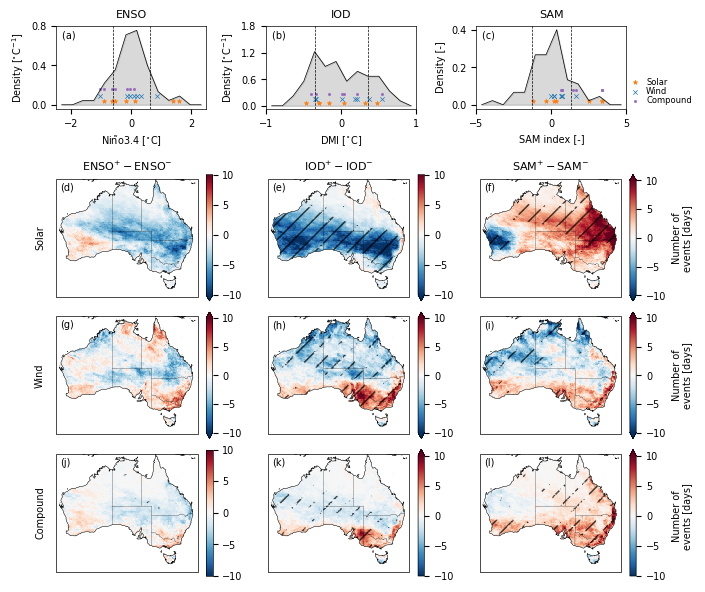

In [ ]:
fig_mode_pdf_and_diff(
    [-2.5, -1, -5],
    [
    aus_events_mssrd_seasonal_total,
    aus_events_100w_seasonal_total,
    aus_events_both_seasonal_total
], 'Winter', scale=None, dividers=[1, 1, 1], signif=True, save_fig=True)

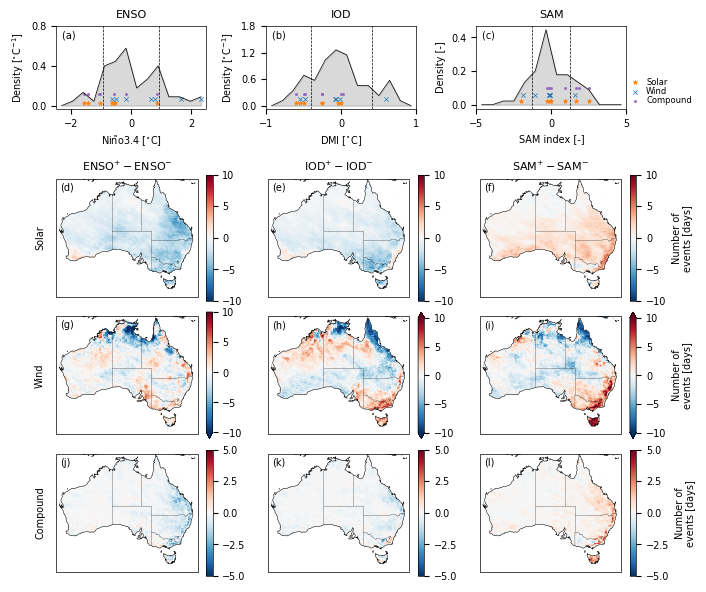

In [73]:
fig_mode_pdf_and_diff(
    [-2.5, -1, -5],
    [
    aus_events_mssrd_seasonal_total,
    aus_events_100w_seasonal_total,
    aus_events_both_seasonal_total
], 'Spring', scale=None, dividers=[1, 1, 2], save_fig=True)

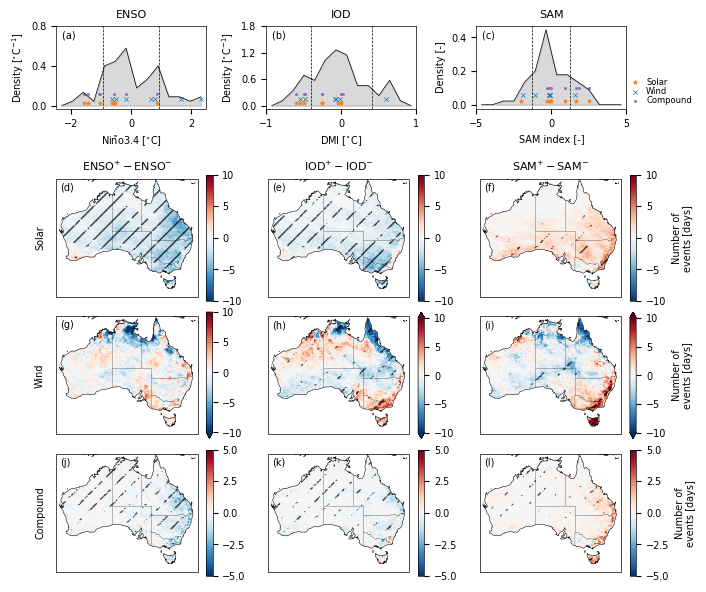

In [ ]:
fig_mode_pdf_and_diff(
    [-2.5, -1, -5],
    [
    aus_events_mssrd_seasonal_total,
    aus_events_100w_seasonal_total,
    aus_events_both_seasonal_total
], 'Spring', scale=None, dividers=[1, 1, 2], signif=True, save_fig=True)

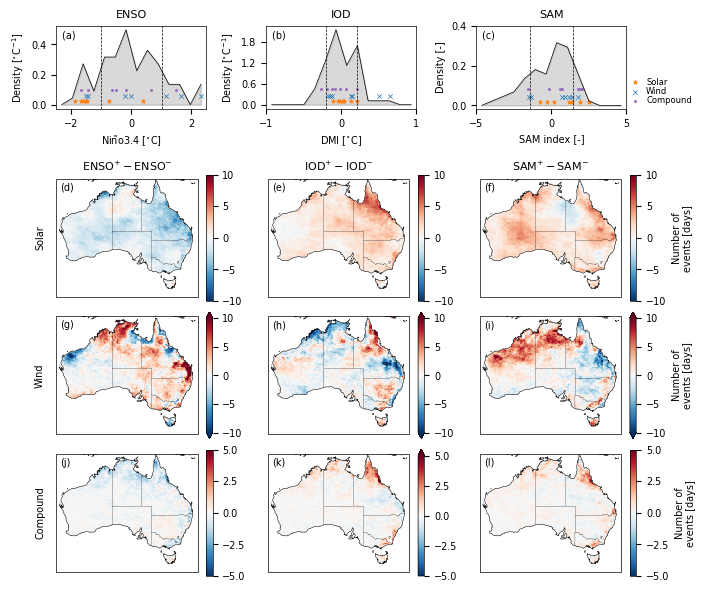

In [74]:
fig_mode_pdf_and_diff(
    [-2.5, -1, -5],
    [
    aus_events_mssrd_seasonal_total,
    aus_events_100w_seasonal_total,
    aus_events_both_seasonal_total
], 'Summer', scale=None, dividers=[1, 1, 2], save_fig=True)

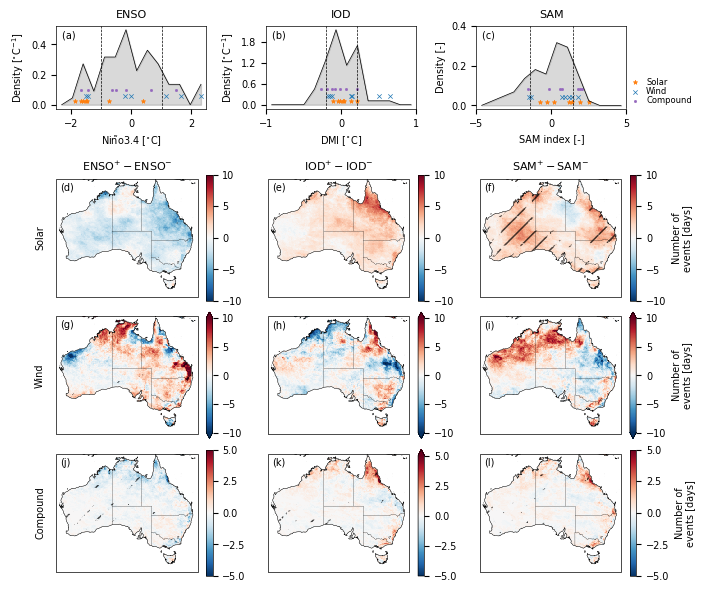

In [89]:
fig_mode_pdf_and_diff(
    [-2.5, -1, -5],
    [
    aus_events_mssrd_seasonal_total,
    aus_events_100w_seasonal_total,
    aus_events_both_seasonal_total
], 'Summer', scale=None, dividers=[1, 1, 2], signif=True, save_fig=True)

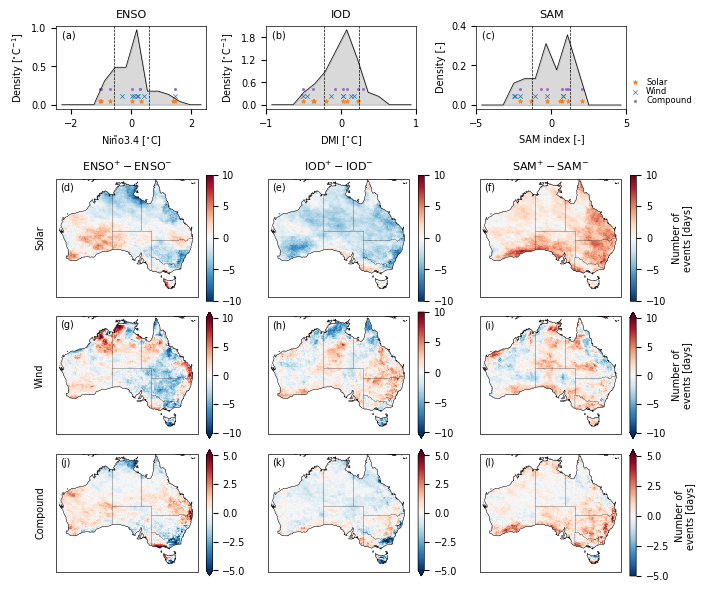

In [75]:
fig_mode_pdf_and_diff(
    [-2.5, -1, -5],
    [
    aus_events_mssrd_seasonal_total,
    aus_events_100w_seasonal_total,
    aus_events_both_seasonal_total
], 'Autumn', scale=None, dividers=[1, 1, 2], save_fig=True)

KeyboardInterrupt: 

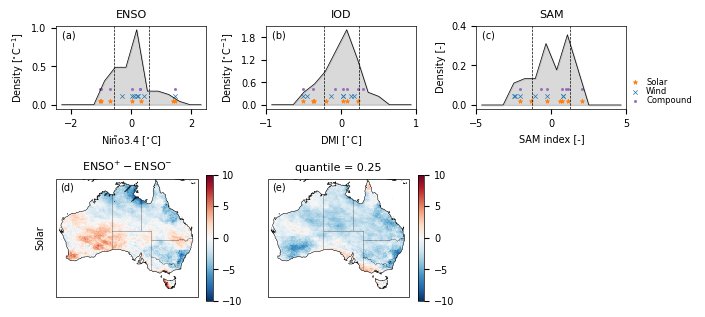

In [90]:
fig_mode_pdf_and_diff(
    [-2.5, -1, -5],
    [
    aus_events_mssrd_seasonal_total,
    aus_events_100w_seasonal_total,
    aus_events_both_seasonal_total
], 'Autumn', scale=None, dividers=[1, 1, 2], signif=True, save_fig=True)

# Close cluster

In [55]:
client.close()
cluster.close()